In [2]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

models = [
    'adone', 'anomalous', 'anomalydae', 'cola', 'conad', 'dmgd', 
    'dominant', 'done', 'gaan', 'gadnr', 'gae', 'guide'
]

log_dir = '/data1/yuchen/Fair-GAD/src_7/output'  
all_results = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

trial_pattern = r"Trial (\d+) finished with value: ([\d.]+) and parameters: \{([^}]+)\}. Best is trial (\d+) with value: ([\d.]+)"
outlier_pattern = r"Trial (\d+) (\w+)\s*(cf)?\s*:\s*\{\s*([^}]*)\}"

for file_name in os.listdir(log_dir):
    for model in models:
        if f"model_{model}_" in file_name:
            file_path = os.path.join(log_dir, file_name)
            with open(file_path, 'r') as file:
                text = file.read()
                
                config = defaultdict(dict)
                result = defaultdict(lambda: defaultdict(dict))

                trial_matches = re.findall(trial_pattern, text)
                for match in trial_matches:
                    trial_id, value, params, best_trial, best_value = match
                    param_dict = {param.split(": ")[0].strip("'"): float(param.split(": ")[1]) for param in params.split(", ")}
                    config[int(trial_id)] = param_dict
                last_best_trial = int(trial_matches[-1][3]) if trial_matches else None
                
                outlier_matches = re.findall(outlier_pattern, text)
                for match in outlier_matches:
                    trial_id, outlier_type, cf_flag, eval_str = match
                    eval_dict = {eval_item.split(": ")[0].strip("'"): float(eval_item.split(": ")[1]) for eval_item in eval_str.split(", ")}
                    cf_present = 1 if cf_flag else 0
                    result[outlier_type][int(trial_id)][cf_present] = eval_dict

                for outlier_type, trials in result.items():
                    for trial_id, cf_data in trials.items():
                        if 0 in cf_data and 1 in cf_data:
                            cf_value = cf_data[0].get('cf')
                            cf_data[1]['cf'] = cf_value

                sen_rate = re.search(r'flip_(\d+\.\d+)', file_name).group(1)

                all_results[model][sen_rate]['eval'] = result
                all_results[model][sen_rate]['config'] = config 
                all_results[model][sen_rate]['best_trial'] = last_best_trial


In [3]:
best_trials_data = []
for model in all_results:
    for sen_rate in all_results[model]:
        best_trial_id = all_results[model][sen_rate]['best_trial']
        if best_trial_id is not None:
            best_trial_results = all_results[model][sen_rate]['eval']
            for outlier_type in best_trial_results:
                if best_trial_id in best_trial_results[outlier_type]:
                    for cf_present in best_trial_results[outlier_type][best_trial_id]:
                        auc = best_trial_results[outlier_type][best_trial_id][cf_present].get('auc', None)
                        cf = best_trial_results[outlier_type][best_trial_id][cf_present].get('cf', None)
                        best_trials_data.append({
                            'model': model,
                            'sen_rate': float(sen_rate),
                            'outlier_type': outlier_type,
                            'cf_present': cf_present,
                            'auc': auc,
                            'cf': cf
                        })


df_best_trials = pd.DataFrame(best_trials_data)
output_file = 'fig/results.xlsx'
df_best_trials.to_excel(output_file, index=False)

In [4]:
data = []
for model, sen_rates in all_results.items():
    for sen_rate, data_dict in sen_rates.items():
        for outlier_type, trials in data_dict['eval'].items():
            for trial_id, cf_data in trials.items():
                for cf_present, eval_dict in cf_data.items():
                    data.append({
                        'model': model,
                        'sen_rate': float(sen_rate),
                        'outlier_type': outlier_type,
                        'cf_present': cf_present,
                        'auc': eval_dict.get('auc', None),
                        'cf': eval_dict.get('cf', None)
                    })

df = pd.DataFrame(data)


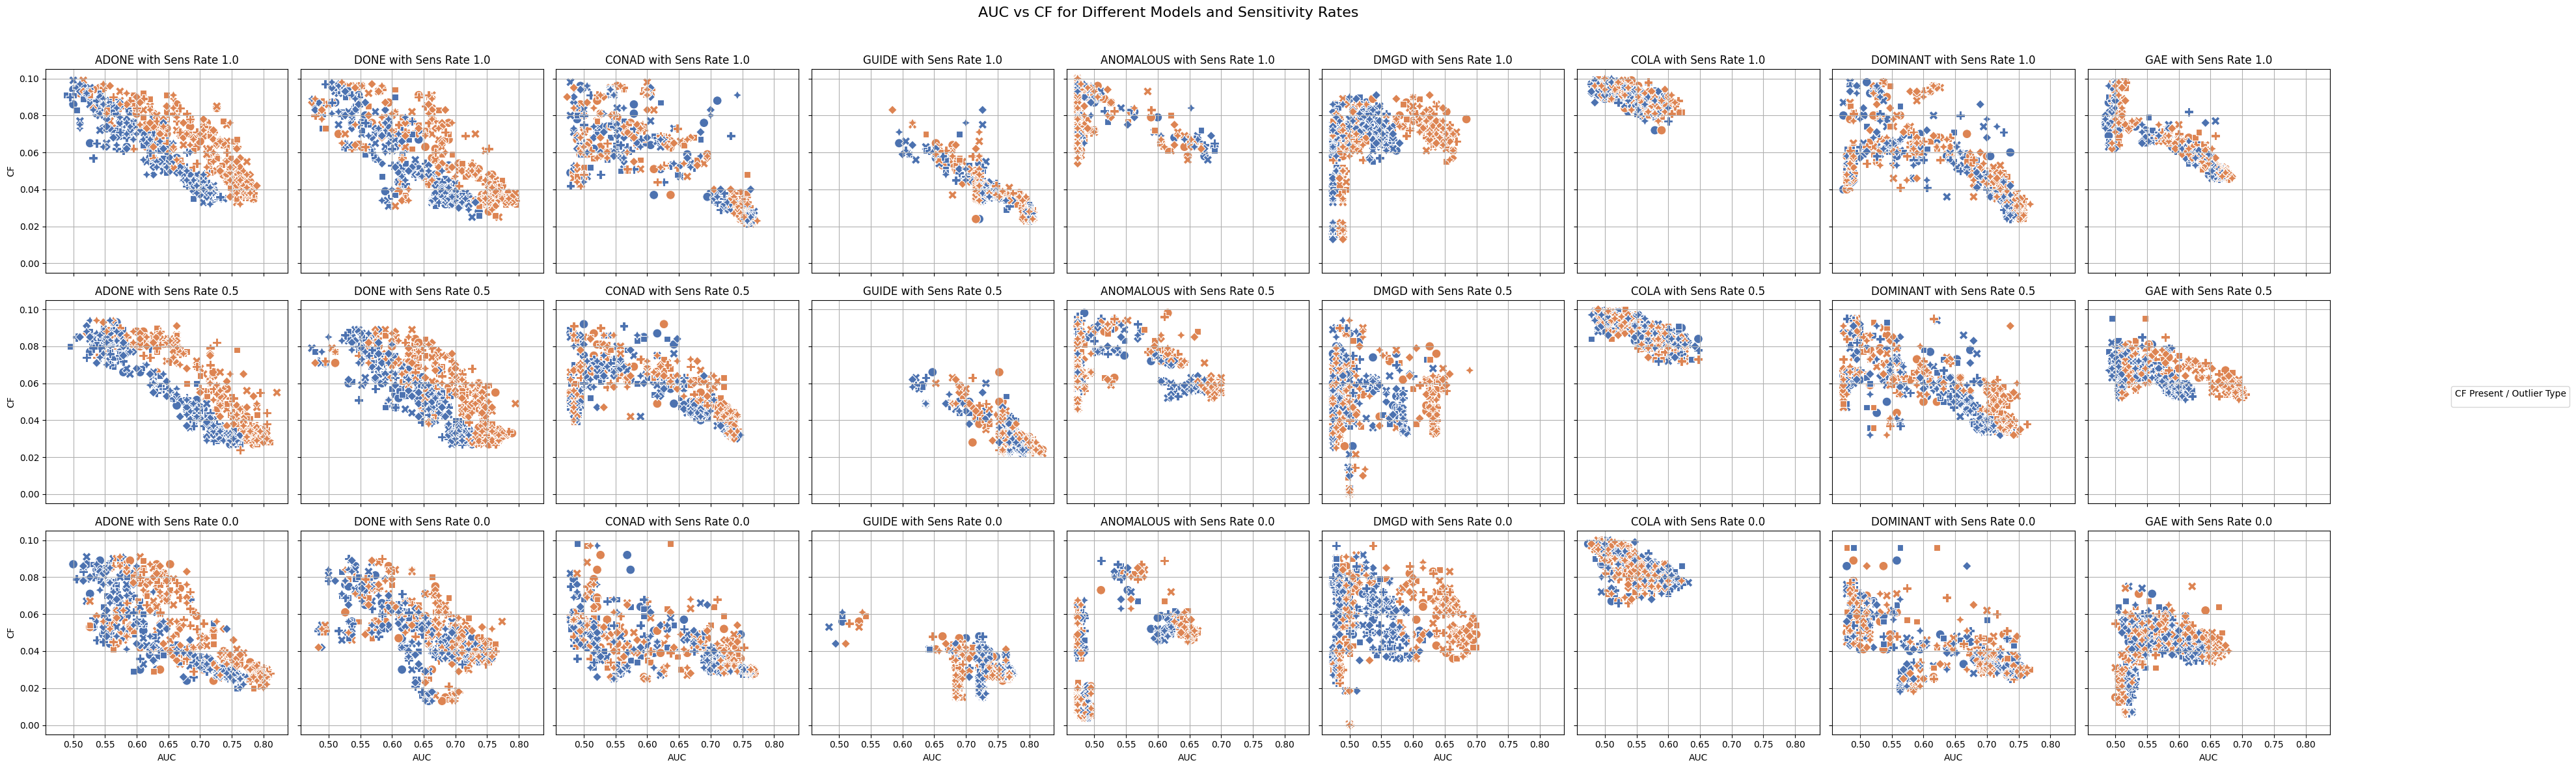

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def plot_auc_vs_cf(ax, df, model, sen_rate, show_outlier_inject=True):
    if show_outlier_inject:
        sns.scatterplot(data=df, x='auc', y='cf', hue='cf_present', style='outlier_type', palette='deep', s=100, ax=ax, legend=False)
    else:
        sns.scatterplot(data=df, x='auc', y='cf', hue='cf_present', palette='deep', s=100, ax=ax, legend=False)
    ax.set_title(f'{model.upper()} with Sens Rate {sen_rate}')
    ax.set_xlabel('AUC')
    ax.set_ylabel('CF')
    ax.grid(True)

models = df['model'].unique()
sen_rates = df['sen_rate'].unique()

fig, axes = plt.subplots(len(sen_rates), len(models), figsize=(4 * len(models), 4 * len(sen_rates)), sharex=True, sharey=True)

for i, sen_rate in enumerate(sen_rates):
    for j, model in enumerate(models):
        ax = axes[i, j]
        df_filtered = df[(df['model'] == model) & (df['sen_rate'] == sen_rate)]
        if not df_filtered.empty:
            plot_auc_vs_cf(ax, df_filtered, model, sen_rate, show_outlier_inject=True)

plt.suptitle('AUC vs CF for Different Models and Sensitivity Rates', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.5), title='CF Present / Outlier Type')

plt.show()


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def get_best_trial_values(df):
    # best_trials = df.groupby(['model', 'sen_rate', 'outlier_type'])['auc'].idxmax()
    # best_values = df.loc[best_trials][['model', 'sen_rate', 'outlier_type','auc', 'cf']]
    best_trials = df.groupby(['model', 'sen_rate'])['auc'].idxmax()
    best_values = df.loc[best_trials][['model', 'sen_rate', 'auc', 'cf']]
    return best_values

df_best_values = get_best_trial_values(df)
df_best_values

每个模型和灵敏度率组合的最佳试验的 AUC 和 CF:


,model,sen_rate,auc,cf
1541,adone,0.0,0.810526,0.028
735,adone,0.5,0.821053,0.055
473,adone,1.0,0.789474,0.042
8460,anomalous,0.0,0.663158,0.051
7266,anomalous,0.5,0.700000,0.063
7777,anomalous,1.0,0.689474,0.063
10778,cola,0.0,0.631579,0.077
11897,cola,0.5,0.647368,0.084
11461,cola,1.0,0.621053,0.082
3641,conad,0.0,0.768421,0.030


In [7]:
abd = df.iloc[:10000]
best_trials = abd.groupby(['model', 'sen_rate'])['auc'].idxmax()
best_trials

model      sen_rate
adone      0.0         1541
           0.5          735
           1.0          473
anomalous  0.0         8460
           0.5         7266
           1.0         7777
conad      0.0         3641
           0.5         5316
           1.0         4722
dmgd       0.0         9535
           0.5         9393
done       0.0         1931
           0.5         2515
           1.0         3039
guide      0.0         5980
           0.5         5405
           1.0         6577
Name: auc, dtype: int64